In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def download_dataset(url):
    d = pd.read_csv(url) # POTENTIALLY: apply parse_dates, based on the dataset format
    ids = d.id
    d.drop(['id'], axis = 1, inplace = True)
    print(d.info(show_counts = True))
    return d, ids

In [4]:
train, _ = download_dataset("train.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB
None


In [5]:
def categorical_handling(categories, names, df):
    for c, n in zip(categories, names):
        ohe = LabelEncoder() #OneHotEncoder(sparse_output = False)
        encs = ohe.fit_transform(df[[c]])
        encs_df = pd.DataFrame(encs)
        cols = []
        cols.append(""+n+"")
        encs_df.columns = cols
        df.drop(c, axis = 1, inplace = True)
        df = pd.concat([df, encs_df], axis = 1)
    return df

In [6]:
catv = ['Geography', 'Gender'] #, 'IsActiveMember', 'HasCrCard', 'NumOfProducts']
names = ['Geography', 'Gender'] #, 'Act', 'Cred', 'Prod']
train = categorical_handling(catv, names, train)

In [7]:
set_config(display="Text")

In [8]:
train.drop(['CustomerId', 'Surname'], axis = 1, inplace = True)

In [9]:
train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography,Gender
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,2,0
165030,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1
165031,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1
165032,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,2,0


In [10]:
X = train.drop(['Exited', "Tenure"], axis=1)
y = train[['Exited', "Tenure"]]
y['Exited'] = y['Exited'].astype(bool)
y = Surv.from_dataframe('Exited', "Tenure", y)

In [11]:
X = train.drop(['Exited', "Tenure"], axis=1)
y = train[['Exited', "Tenure"]]
y['Exited'] = y['Exited'].astype(bool)
# Dividi in set di train e di test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

X_train_df = pd.DataFrame(X_train, columns=X.columns, index = X_train.index)
X_test_df = pd.DataFrame(X_test, columns=X.columns, index = X_test.index)
y_train_df = pd.DataFrame(y_train, columns=y.columns, index = y_train.index)
y_test_df = pd.DataFrame(y_test, columns=y.columns, index = y_test.index)

# Scaling delle features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert y to right format for Cox
y_train = Surv.from_dataframe('Exited', "Tenure", y_train)
y_test = Surv.from_dataframe('Exited', "Tenure", y_test)

In [12]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train_scaled, y_train)

CoxPHSurvivalAnalysis()

In [13]:
pd.Series(cph.coef_, index = X.columns)

CreditScore       -0.190161
Age                4.115570
Balance            0.358434
NumOfProducts     -1.700524
HasCrCard         -0.092738
IsActiveMember    -0.838755
EstimatedSalary    0.133764
Geography          0.134858
Gender            -0.433134
dtype: float64

In [14]:
# FUNCTION TAKEN FROM SCIKIT-SURVIVAL DOCUMENTATION
def fit_and_score_features(X, y):
    n_features = X.shape[1] # Take the number of features
    scores = np.empty(n_features) # For each feature we are going to compute a score
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1] # Select each feature alone
        m.fit(Xj, y) # Fit the model by considering the selected feature
        scores[j] = m.score(Xj, y) # Compute the C-index score
    return scores


scores = fit_and_score_features(X_train_scaled, y_train) #X.values
pd.Series(scores, index=X.columns).sort_values(ascending=False)

Age                0.707375
NumOfProducts      0.636003
IsActiveMember     0.602733
Gender             0.573731
Balance            0.567730
Geography          0.541067
CreditScore        0.513728
EstimatedSalary    0.510832
HasCrCard          0.510789
dtype: float64

In [15]:
# Predict risk scores for the test set
prediction = cph.predict(X_test_scaled)
X_test_df['preds'] = prediction

# Compute concordance index
result = concordance_index_censored(y_test["Exited"], y_test["Tenure"], prediction)
print("Concordance index: ", result[0])

# Compute score
print("Score: ", cph.score(X_test_scaled, y_test))

Concordance index:  0.7576206916538091
Score:  0.7576206916538091


In [16]:
# Predict survival functions
surv_func = cph.predict_survival_function(X_test_scaled, return_array = True)
df_surv = pd.DataFrame(surv_func.T, columns = X_test_df.index)
df_surv

,77006,32268,117133,157989,129796,8751,18483,136920,38968,48897,...,91616,72777,30441,22682,73534,103340,114045,122823,152822,34543
0,0.997946,0.993443,0.979691,0.997259,0.997616,0.995879,0.993706,0.995866,0.996771,0.992182,...,0.996973,0.998655,0.990770,0.992424,0.998489,0.987630,0.998621,0.993695,0.980421,0.988294
1,0.991640,0.973498,0.919635,0.988854,0.990301,0.983280,0.974551,0.983230,0.986879,0.968460,...,0.987700,0.994520,0.962846,0.969425,0.993846,0.950448,0.994381,0.974506,0.922438,0.953059
2,0.985170,0.953323,0.861485,0.980250,0.982805,0.970438,0.955159,0.970349,0.976769,0.944560,...,0.978214,0.990268,0.934838,0.946236,0.989074,0.913524,0.990022,0.955080,0.866162,0.917994
3,0.977231,0.928963,0.794663,0.969718,0.973617,0.954796,0.931722,0.954662,0.964415,0.915833,...,0.966616,0.985038,0.901342,0.918339,0.983207,0.869859,0.984660,0.931604,0.801324,0.876429
4,0.967791,0.900556,0.721297,0.957231,0.962707,0.936362,0.904361,0.936175,0.949800,0.882517,...,0.952882,0.978799,0.862736,0.885952,0.976214,0.820217,0.978265,0.904198,0.729906,0.829038
5,0.957135,0.869214,0.645847,0.943185,0.950412,0.915770,0.874132,0.915524,0.933399,0.845994,...,0.937455,0.971731,0.820715,0.850403,0.968298,0.767044,0.971022,0.873921,0.656183,0.778103
6,0.946143,0.837680,0.575535,0.928752,0.937753,0.894771,0.843673,0.894467,0.916592,0.809503,...,0.921627,0.964412,0.779058,0.814837,0.960109,0.715244,0.963523,0.843415,0.587199,0.728299
7,0.931577,0.797114,0.492983,0.909711,0.921014,0.867319,0.804423,0.866943,0.894491,0.762951,...,0.900786,0.954668,0.726410,0.769393,0.949218,0.651126,0.953541,0.804109,0.505810,0.666380
8,0.910325,0.740381,0.391576,0.882109,0.896666,0.828037,0.749393,0.827561,0.862598,0.698613,...,0.870655,0.940355,0.654609,0.706444,0.933246,0.566231,0.938884,0.749005,0.405139,0.583882
9,0.873789,0.649441,0.260191,0.835162,0.855025,0.762642,0.660823,0.762013,0.808765,0.597485,...,0.819635,0.915478,0.544194,0.607125,0.905555,0.441879,0.913422,0.660332,0.273229,0.461793


In [17]:
threshold = 0.5
predicted_time_to_churn = (df_surv <= threshold)
churns = predicted_time_to_churn.idxmax().where(predicted_time_to_churn.any())


X_test_df['absolute_time_to_churn'] = churns
X_test_df['absolute_time_to_churn'].fillna(y_train_df.Tenure.max()+1, inplace=True)

X_test_df['Churn_Prediction'] = (X_test_df['absolute_time_to_churn'] <= y_train_df.Tenure.max()).astype(int)


In [18]:
def evaluate_classification(df_resulting):
  print(classification_report(df_resulting.Exited.astype(int), df_resulting.Churn_Prediction, digits = 4))
  print(confusion_matrix(df_resulting.Exited.astype(int), df_resulting.Churn_Prediction))
  cm = confusion_matrix(df_resulting.Exited.astype(int), df_resulting.Churn_Prediction)
  tn, fp, fn, tp = cm.ravel()

  print(f"True Positives (TP): {tp}")
  print(f"True Negatives (TN): {tn}")
  print(f"False Positives (FP): {fp}")
  print(f"False Negatives (FN): {fn}")

In [19]:
X_test_final = pd.concat([X_test_df, y_test_df], axis = 1)
X_test_final

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography,Gender,preds,absolute_time_to_churn,Churn_Prediction,Exited,Tenure
77006,715,31.0,0.00,2,1.0,1.0,143204.41,0,0,-0.818367,11.0,0,True,2
32268,656,29.0,137964.51,1,1.0,0.0,64443.75,2,1,0.344576,11.0,0,False,6
117133,545,55.0,133676.65,1,0.0,1.0,17095.49,2,0,1.482123,7.0,1,True,1
157989,625,33.0,0.00,1,1.0,1.0,157932.75,0,1,-0.529348,11.0,0,False,8
129796,708,39.0,0.00,2,1.0,1.0,143030.09,2,1,-0.669171,11.0,0,False,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103340,602,42.0,98362.35,2,0.0,0.0,152843.53,1,0,0.982274,9.0,1,False,7
114045,506,37.0,125843.66,3,1.0,1.0,54865.41,1,1,-1.217039,11.0,0,True,8
122823,751,44.0,132088.57,1,1.0,1.0,179834.95,1,1,0.305287,11.0,0,False,6
152822,721,52.0,0.00,1,0.0,0.0,192013.23,0,1,1.445130,8.0,1,True,1


In [20]:
evaluate_classification(X_test_final)

              precision    recall  f1-score   support

           0     0.9110    0.7660    0.8322     26110
           1     0.4471    0.7165    0.5506      6897

    accuracy                         0.7556     33007
   macro avg     0.6790    0.7412    0.6914     33007
weighted avg     0.8140    0.7556    0.7734     33007

[[19999  6111]
 [ 1955  4942]]
True Positives (TP): 4942
True Negatives (TN): 19999
False Positives (FP): 6111
False Negatives (FN): 1955


In [21]:
def evaluate_buckets(df_resulting):
  tp = df_resulting[(df_resulting.Exited == 1) & (df_resulting.Churn_Prediction == 1)]
  if tp.shape[0] > 0:

    tp['loss'] = tp.Tenure - tp.absolute_time_to_churn
    loss_array = tp['loss']
    positive_values = loss_array[loss_array > 0]
    negative_values = loss_array[loss_array < 0]

    if len(positive_values) > 0:
        pos_count = len(positive_values)
        pos_avg = np.mean(positive_values)
        pos_std = np.std(positive_values)
        pos_median=np.median(positive_values)
    else:
        pos_count = 0
        pos_avg = pos_std = pos_median = np.nan

    if len(negative_values) > 0:
        neg_count = len(negative_values)
        neg_avg = np.mean(negative_values)
        neg_std = np.std(negative_values)
        neg_median=np.median(negative_values)
    else:
        neg_count = 0
        neg_avg = neg_std = neg_median = np.nan

    print("True positive: ", len(tp))
    print(f"Supporto anticipi: {pos_count}, ({(pos_count/len(tp))*100}%)")
    print(f"Supporto ritardi: {neg_count}, ({(neg_count/len(tp))*100}%)")
    print(f"Anticipo medio: {pos_avg},{pos_median} +/- {pos_std}")
    print(f"Ritardo medio: {neg_avg},{neg_median} +/- {neg_std}")

In [22]:
evaluate_buckets(X_test_final)

True positive:  4942
Supporto anticipi: 700, (14.164305949008499%)
Supporto ritardi: 3821, (77.31687575880211%)
Anticipo medio: 1.9785714285714286,2.0 +/- 1.169052468227747
Ritardo medio: -4.453807903690134,-4.0 +/- 2.3865571074815475


In [23]:
from sksurv.metrics import concordance_index_ipcw, brier_score

In [24]:
def compute_cic_brier(df_surv, df_test, tau=10, brier_times=None):
    events = df_test['Exited'].astype(bool).values
    times = df_test['Tenure'].values
    y_surv = Surv.from_arrays(events, times)
    
    max_feature_time = int(df_test.absolute_time_to_churn.max())
    print(max_feature_time)
    tau_feature = min(tau, max_feature_time)
    risk_scores = 1 - df_surv[int(tau_feature)].values
    print(risk_scores)
    
    print("Computing C-index...")
    try:
        #concordance_index_censored(y_test["event"], y_test["survival_time"], prediction)
        cic = concordance_index_ipcw(y_surv, y_surv, risk_scores, tau=tau)
        print(f"C-index at tau={tau}: {cic[0]:.4f}")
    except Exception as e:
        print(f"C-index computation failed: {e}")
        cic = None
    
    print("\nComputing Brier score...")
    
    if brier_times is None:
        brier_times = [2 * i for i in range(1, int(tau/2) + 1)]
        brier_times = [t for t in brier_times if t <= max_feature_time]
    
    print(f"Evaluating Brier score at times: {brier_times}")
    
    try:
        surv_cols = [int(i) for i in range(max_feature_time)]
        all_survival_probs = df_surv[surv_cols].values 
        
        survival_estimates = np.column_stack([
            all_survival_probs[:, t] for t in brier_times
        ])  
        
        print(f"Survival estimates shape: {survival_estimates.shape}")
        print(f"Sample estimates: {survival_estimates[0, :]}")
        
        times_eval, brier_scores = brier_score(
            y_surv, y_surv, survival_estimates, brier_times
        )
        
        print("Brier Scores:")
        for time_point, score in zip(times_eval, brier_scores):
            print(f"  Time {time_point}: {score:.4f}")
            
    except Exception as e:
        print(f"Brier score computation failed: {e}")
        import traceback
        traceback.print_exc()
        brier_scores = None
        times_eval = None
    
    return cic, (times_eval, brier_scores)

In [27]:
compute_cic_brier(df_surv.T, X_test_final, 9)

11
[0.12621101 0.35055851 0.73980918 ... 0.339668   0.72677109 0.53820727]
Computing C-index...
C-index at tau=9: 0.7598

Computing Brier score...
Evaluating Brier score at times: [2, 4, 6, 8]
Survival estimates shape: (33007, 4)
Sample estimates: [0.98517003 0.96779118 0.94614319 0.91032453]
Brier Scores:
  Time 2: 0.0529
  Time 4: 0.1039
  Time 6: 0.1494
  Time 8: 0.2123


((np.float64(0.7598330855883225),
  np.int64(92884908),
  np.int64(29715896),
  np.int64(10),
  np.int64(17815305)),
 (array([2, 4, 6, 8]),
  array([0.05289287, 0.1039169 , 0.14935102, 0.21229134])))

In [31]:
# Create dataframe for plotting survival curves
df_surv_final = pd.concat([df_surv, X_test_final[['Exited', 'Tenure', 'absolute_time_to_churn', 'Churn_Prediction']].T], axis = 0)
df_surv_final.T

,0,1,2,3,4,5,6,7,8,9,10,Exited,Tenure,absolute_time_to_churn,Churn_Prediction
77006,0.997946,0.99164,0.98517,0.977231,0.967791,0.957135,0.946143,0.931577,0.910325,0.873789,0.827191,True,2,11.0,0
32268,0.993443,0.973498,0.953323,0.928963,0.900556,0.869214,0.83768,0.797114,0.740381,0.649441,0.544997,False,6,11.0,0
117133,0.979691,0.919635,0.861485,0.794663,0.721297,0.645847,0.575535,0.492983,0.391576,0.260191,0.150586,True,1,7.0,1
157989,0.997259,0.988854,0.98025,0.969718,0.957231,0.943185,0.928752,0.909711,0.882109,0.835162,0.776237,False,8,11.0,0
129796,0.997616,0.990301,0.982805,0.973617,0.962707,0.950412,0.937753,0.921014,0.896666,0.855025,0.802322,False,9,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103340,0.98763,0.950448,0.913524,0.869859,0.820217,0.767044,0.715244,0.651126,0.566231,0.441879,0.317121,False,7,9.0,1
114045,0.998621,0.994381,0.990022,0.98466,0.978265,0.971022,0.963523,0.953541,0.938884,0.913422,0.880433,True,8,11.0,0
122823,0.993695,0.974506,0.95508,0.931604,0.904198,0.873921,0.843415,0.804109,0.749005,0.660332,0.557892,False,6,11.0,0
152822,0.980421,0.922438,0.866162,0.801324,0.729906,0.656183,0.587199,0.50581,0.405139,0.273229,0.161303,True,1,8.0,1


In [42]:
def plot_survival_curves_xmonths(df, time_window=10, sample_size=200, churn_col='Exited', figsize=(15, 10)):
    """
    Plot survival curves for x months with green=non-churners, red=churners
    
    Parameters:
    - df: Your dataframe with survival probabilities in columns 0-max_num_Years
    - time_window: Years to show (default 10 for 6 months)
    - sample_size: Max curves to plot per group (for readability)
    - churn_col: Column name indicating churn (default 'Exited')
    """
    
    ub = df.absolute_time_to_churn.max() + 1
    
    survival_cols = [i for i in range(min(time_window, ub))]
    df_survival = df[survival_cols].copy()
    df_survival = df_survival.apply(pd.to_numeric, errors="coerce")
    churn_labels = df[churn_col].values
    
    time_points = np.arange(len(survival_cols))
    
    churner_mask = churn_labels == 1
    non_churner_mask = churn_labels == 0
    
    print(f"Dataset summary:")
    print(f"Total samples: {len(df)}")
    print(f"Churners: {churner_mask.sum()} ({churner_mask.mean()*100:.1f}%)")
    print(f"Non-churners: {non_churner_mask.sum()} ({non_churner_mask.mean()*100:.1f}%)")
    print(f"Time window: {len(survival_cols)} Years")
    
    if sample_size:
        churner_indices = np.where(churner_mask)[0]
        non_churner_indices = np.where(non_churner_mask)[0]
        
        if len(churner_indices) > sample_size:
            churner_sample = np.random.choice(churner_indices, sample_size, replace=False)
        else:
            churner_sample = churner_indices
            
        if len(non_churner_indices) > sample_size:
            non_churner_sample = np.random.choice(non_churner_indices, sample_size, replace=False)
        else:
            non_churner_sample = non_churner_indices
    else:
        churner_sample = np.where(churner_mask)[0]
        non_churner_sample = np.where(non_churner_mask)[0]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    for idx in non_churner_sample:
        survival_curve = df_survival.iloc[idx].values
        ax1.plot(time_points, survival_curve, color='green', alpha=0.3, linewidth=0.8)
    
    for idx in churner_sample:
        survival_curve = df_survival.iloc[idx].values
        ax1.plot(time_points, survival_curve, color='red', alpha=0.3, linewidth=0.8)
    
    ax1.set_title(f'Individual Survival Curves (Sample: {len(churner_sample)+len(non_churner_sample)} curves)')
    ax1.set_ylabel('Survival Probability')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    ax1.plot([], [], color='green', alpha=0.7, label=f'Non-Churners (n={non_churner_mask.sum()})')
    ax1.plot([], [], color='red', alpha=0.7, label=f'Churners (n={churner_mask.sum()})')
    ax1.legend()
    
    if non_churner_mask.sum() > 0:
        non_churner_data = df_survival.iloc[non_churner_mask]
        mean_non_churner = non_churner_data.mean(axis=0)
        std_non_churner = non_churner_data.std(axis=0)
        
        ax2.plot(time_points, mean_non_churner, color='darkgreen', linewidth=3, 
                label=f'Non-Churners Mean (n={non_churner_mask.sum()})')
        ax2.fill_between(time_points, 
                        mean_non_churner - std_non_churner,
                        mean_non_churner + std_non_churner,
                        color='green', alpha=0.2, label='±1 Std Dev')
    
    if churner_mask.sum() > 0:
        churner_data = df_survival.iloc[churner_mask]
        mean_churner = churner_data.mean(axis=0)
        std_churner = churner_data.std(axis=0)
        
        ax2.plot(time_points, mean_churner, color='darkred', linewidth=3,
                label=f'Churners Mean (n={churner_mask.sum()})')
        ax2.fill_between(time_points,
                        mean_churner - std_churner,
                        mean_churner + std_churner,
                        color='red', alpha=0.2)
    
    ax2.set_title('Mean Survival Curves ± Standard Deviation')
    ax2.set_ylabel('Survival Probability')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    key_times = [2*i for i in range(1, time_window+1)]
    key_times = [t for t in key_times if t < len(survival_cols)]
    
    churner_probs_at_times = []
    non_churner_probs_at_times = []
    
    for t in key_times:
        if churner_mask.sum() > 0:
            churner_probs_at_times.append(df_survival.iloc[churner_mask, t].mean())
        if non_churner_mask.sum() > 0:
            non_churner_probs_at_times.append(df_survival.iloc[non_churner_mask, t].mean())
    
    x_pos = np.arange(len(key_times))
    width = 0.35
    
    if churner_mask.sum() > 0:
        ax3.bar(x_pos - width/2, churner_probs_at_times, width, 
               color='red', alpha=0.7, label='Churners')
    if non_churner_mask.sum() > 0:
        ax3.bar(x_pos + width/2, non_churner_probs_at_times, width,
               color='green', alpha=0.7, label='Non-Churners')
    
    ax3.set_title('Survival Probability at Key Time Points')
    ax3.set_ylabel('Survival Probability')
    ax3.set_xlabel('Years')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f'{t}y' for t in key_times])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    lower = key_times[-1] - 1
    if lower < len(survival_cols):  
        survival_10 = df_survival.iloc[:, lower]
        
        if churner_mask.sum() > 0:
            ax4.hist(survival_10[churner_mask], bins=30, alpha=0.7, color='red', 
                    label=f'Churners (n={churner_mask.sum()})', density=True)
        if non_churner_mask.sum() > 0:
            ax4.hist(survival_10[non_churner_mask], bins=30, alpha=0.7, color='green',
                    label=f'Non-Churners (n={non_churner_mask.sum()})', density=True)
        
        ax4.set_title('Distribution of Survival Probability')
        ax4.set_xlabel('Survival Probability at Year 10')
        ax4.set_ylabel('Density')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    for ax in [ax1, ax2]:
        for month_day in key_times[:-1]:
            if month_day < len(survival_cols):
                ax.axvline(month_day, color='gray', linestyle='--', alpha=0.5)
                ax.text(month_day, 0.95, f'{month_day//30}m', ha='center', fontsize=9)
        ax.set_xlabel('Years')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSurvival Statistics:")
    if lower < len(survival_cols):
        survival_10 = df_survival.iloc[:, lower]
        if churner_mask.sum() > 0:
            print(f"Churners - Mean: {survival_10[churner_mask].mean():.3f}, "
                  f"Std: {survival_10[churner_mask].std():.3f}")
        if non_churner_mask.sum() > 0:
            print(f"Non-churners - Mean: {survival_10[non_churner_mask].mean():.3f}, "
                  f"Std: {survival_10[non_churner_mask].std():.3f}")

Dataset summary:
Total samples: 33007
Churners: 6897 (20.9%)
Non-churners: 26110 (79.1%)
Time window: 10 Years


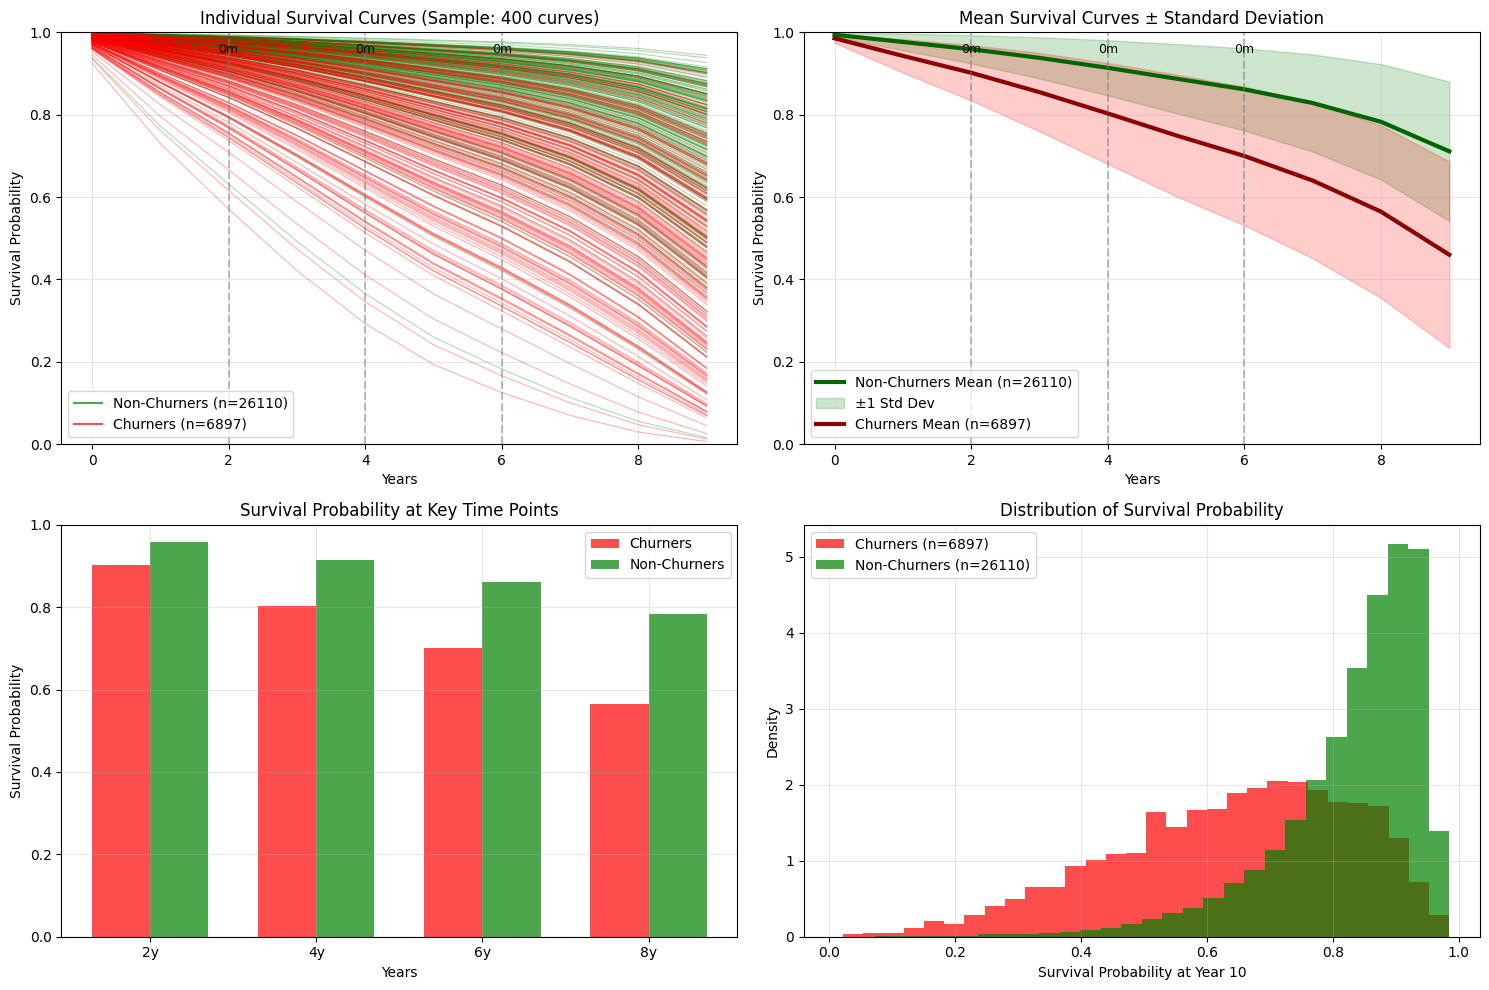


Survival Statistics:
Churners - Mean: 0.640, Std: 0.189
Non-churners - Mean: 0.828, Std: 0.118


In [43]:
plot_survival_curves_xmonths(df_surv_final.T)

In [44]:
df_surv_def = df_surv_final.T
df_surv_def

,0,1,2,3,4,5,6,7,8,9,10,Exited,Tenure,absolute_time_to_churn,Churn_Prediction
77006,0.997946,0.99164,0.98517,0.977231,0.967791,0.957135,0.946143,0.931577,0.910325,0.873789,0.827191,True,2,11.0,0
32268,0.993443,0.973498,0.953323,0.928963,0.900556,0.869214,0.83768,0.797114,0.740381,0.649441,0.544997,False,6,11.0,0
117133,0.979691,0.919635,0.861485,0.794663,0.721297,0.645847,0.575535,0.492983,0.391576,0.260191,0.150586,True,1,7.0,1
157989,0.997259,0.988854,0.98025,0.969718,0.957231,0.943185,0.928752,0.909711,0.882109,0.835162,0.776237,False,8,11.0,0
129796,0.997616,0.990301,0.982805,0.973617,0.962707,0.950412,0.937753,0.921014,0.896666,0.855025,0.802322,False,9,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103340,0.98763,0.950448,0.913524,0.869859,0.820217,0.767044,0.715244,0.651126,0.566231,0.441879,0.317121,False,7,9.0,1
114045,0.998621,0.994381,0.990022,0.98466,0.978265,0.971022,0.963523,0.953541,0.938884,0.913422,0.880433,True,8,11.0,0
122823,0.993695,0.974506,0.95508,0.931604,0.904198,0.873921,0.843415,0.804109,0.749005,0.660332,0.557892,False,6,11.0,0
152822,0.980421,0.922438,0.866162,0.801324,0.729906,0.656183,0.587199,0.50581,0.405139,0.273229,0.161303,True,1,8.0,1


In [45]:
df_surv_churn = df_surv_def[(df_surv_def['Exited'] == True ) & (df_surv_def['Churn_Prediction'] == 1)]
df_surv_churn

,0,1,2,3,4,5,6,7,8,9,10,Exited,Tenure,absolute_time_to_churn,Churn_Prediction
117133,0.979691,0.919635,0.861485,0.794663,0.721297,0.645847,0.575535,0.492983,0.391576,0.260191,0.150586,True,1,7.0,1
127111,0.981124,0.92514,0.870683,0.80778,0.738279,0.666276,0.598635,0.518456,0.41862,0.286379,0.172326,True,4,8.0,1
75248,0.988521,0.953954,0.919529,0.87869,0.832079,0.781925,0.732823,0.671684,0.59005,0.468814,0.344636,True,4,9.0,1
31166,0.976101,0.905954,0.838808,0.762648,0.680344,0.597254,0.521369,0.434385,0.331104,0.204493,0.107319,True,7,7.0,1
58935,0.986652,0.94661,0.906968,0.860255,0.807375,0.751015,0.696409,0.629256,0.541159,0.414056,0.289407,True,8,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20177,0.984761,0.939224,0.894412,0.841965,0.783085,0.720935,0.66135,0.588989,0.495739,0.36508,0.242455,True,5,8.0,1
15003,0.971121,0.887229,0.808203,0.720179,0.62713,0.535582,0.45429,0.364167,0.262094,0.146189,0.066943,True,3,6.0,1
6911,0.988305,0.953103,0.918069,0.87654,0.829187,0.77829,0.72852,0.666639,0.584183,0.462134,0.337751,True,9,9.0,1
22682,0.992424,0.969425,0.946236,0.918339,0.885952,0.850403,0.814837,0.769393,0.706444,0.607125,0.49573,True,8,10.0,1


Dataset summary:
Total samples: 4942
Churners: 4942 (100.0%)
Non-churners: 0 (0.0%)
Time window: 10 Years


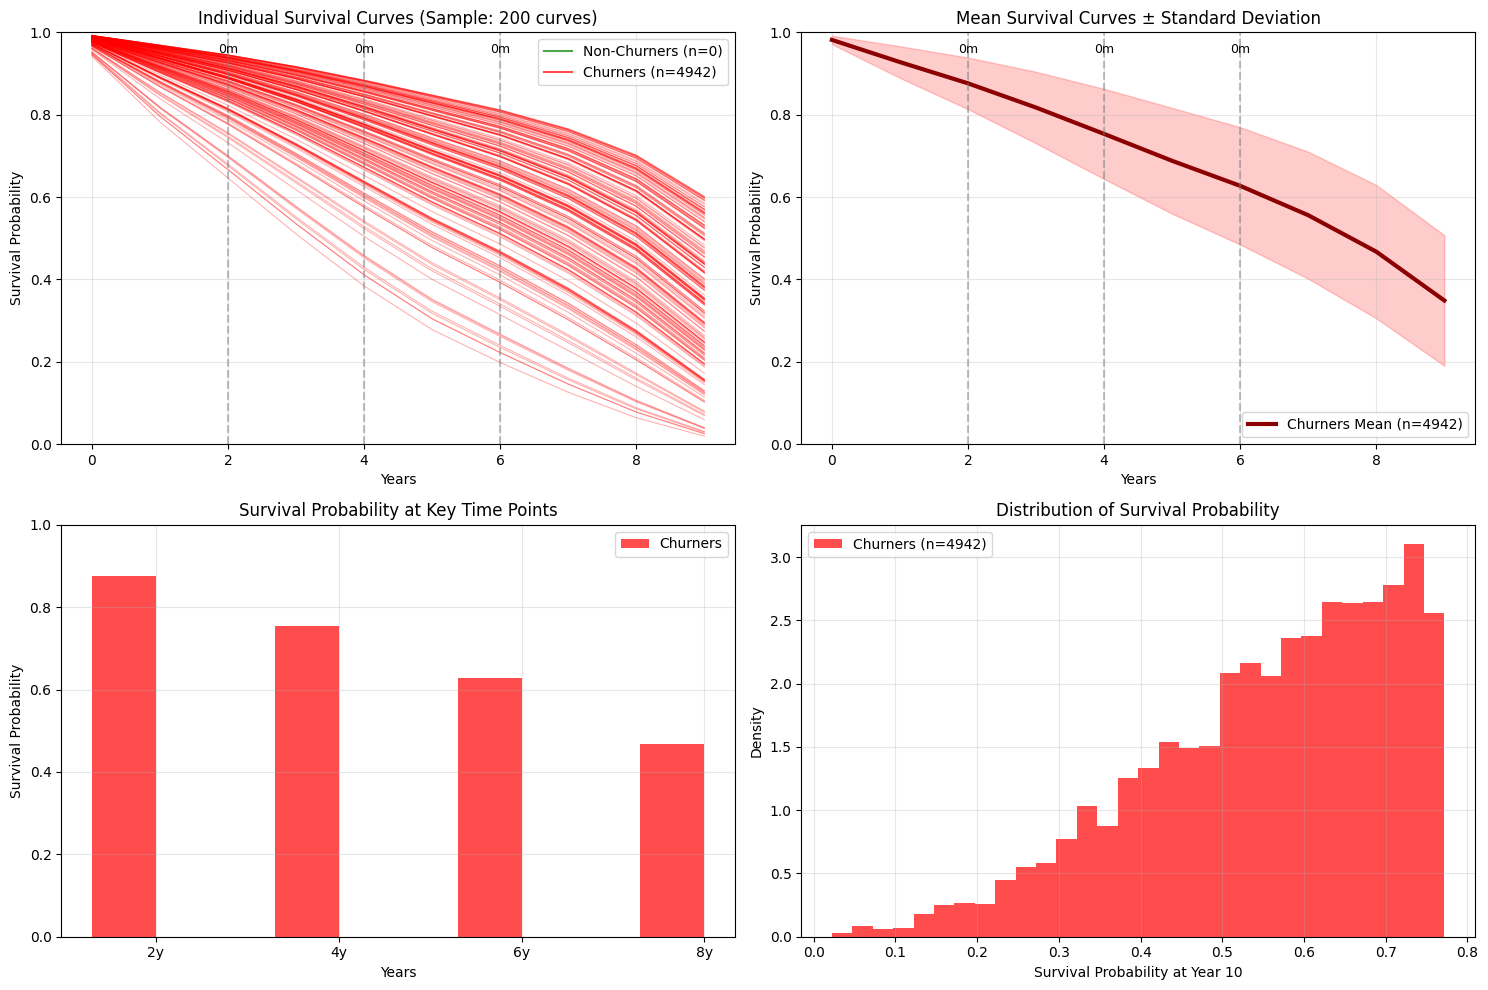


Survival Statistics:
Churners - Mean: 0.556, Std: 0.154


In [46]:
plot_survival_curves_xmonths(df_surv_churn)

In [47]:
### ALTRI GRAFICI

In [91]:
def plot_churn_probability_over_time(df_train, df_test, cox_model, test_features, feature_names=None, customer_indices=None, max_days=None, title=None):
    """
    Traccia la probabilità di abbandono nel tempo per diversi clienti
    
    Parametri:
    -----------
    df_train : pandas DataFrame
        Dati di training con colonne 'duration' e 'event'
    df_test : pandas DataFrame
        Dati di test
    cox_model : modello Cox di scikit-survival
        Modello di sopravvivenza di Cox già addestrato
    test_features : pandas DataFrame
        Features preprocessate per i dati di test
    feature_names : list, optional
        Nomi delle features (se None, usa i nomi delle colonne di test_features)
    customer_indices : list, optional
        Indici di clienti specifici da tracciare. Se None, usa segmenti di rischio.
    max_days : int, optional
        Numero massimo di giorni da tracciare
    title : str, optional
        Titolo del grafico
    """
    from sksurv.nonparametric import kaplan_meier_estimator
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from collections import defaultdict
    used_label_positions = defaultdict(list)
    
    if feature_names is None:
        feature_names = test_features.columns.tolist()
    
    # Preparazione dei dati per Kaplan-Meier
    event_observed = df_train['Exited'].astype(bool).values
    time = df_train['Tenure'].values
    time_points, survival_prob = kaplan_meier_estimator(event_observed, time)
    baseline_survival = pd.DataFrame({'KM_estimate': survival_prob}, index=time_points)
    
    if max_days is None:
        max_days = int(baseline_survival.index.max())
    else:
        baseline_survival = baseline_survival.loc[baseline_survival.index <= max_days]

    full_index = pd.RangeIndex(start=0, stop=max_days + 1)

    baseline_survival_full = baseline_survival.reindex(full_index).ffill().fillna(1.0)
    
    plt.figure(figsize=(12, 7))
    
    if customer_indices is None:
        all_risks = []
        for idx in test_features.index:
            features = test_features.loc[[idx]]
            risk_score = np.exp(cox_model.predict(features))[0]
            all_risks.append(risk_score)
        
        risks = np.array(all_risks)
        print("Risks min max:", risks.min(), risks.max())
        print("Unique risks:", len(np.unique(risks)))
        indices = np.arange(len(risks))
        
        low_risk_idx = test_features.index[indices[risks <= np.percentile(risks, 25)][0]] #.index
        medium_risk_idx = test_features.index[indices[(risks > np.percentile(risks, 45)) & 
                                                     (risks < np.percentile(risks, 55))][67]]
        high_risk_idx = test_features.index[indices[risks >= np.percentile(risks, 75)][1689]]
        
        customer_indices = [low_risk_idx, medium_risk_idx, high_risk_idx]
        print(f"Cliente a basso rischio: {low_risk_idx}. Cliente a medio rischio: {medium_risk_idx}. Cliente ad alto rischio: {high_risk_idx}")
        labels = ['Cliente a Basso Rischio', 'Cliente a Rischio Medio', 'Cliente ad Alto Rischio']
        colors = ['green', 'orange', 'red']
    else:
        labels = [f'Cliente {i}' for i in customer_indices]
        colors = plt.cm.viridis(np.linspace(0, 1, len(customer_indices)))
    
    plt.plot(baseline_survival.index, 1 - baseline_survival['KM_estimate'], 'k--', alpha=0.5, linewidth=1, label='Media della Popolazione')
    
    for i, idx in enumerate(customer_indices):
        customer_features = test_features.loc[[idx]]
        risk_score = np.exp(cox_model.predict(customer_features))[0]
        customer_survival = pd.DataFrame(index=baseline_survival.index)
        customer_survival['KM_estimate'] = baseline_survival['KM_estimate'] ** risk_score
        churn_probability = 1 - customer_survival['KM_estimate']
        plt.plot(customer_survival.index, churn_probability, color=colors[i], linewidth=2, label=f'{labels[i]} (Punteggio di Rischio: {risk_score:.2f})')
        real_time = df_test.loc[idx, 'Tenure']
        if real_time <= max_days:
            if real_time in churn_probability.index:
                prob_at_real_time = churn_probability.loc[real_time]
            else:
                prob_at_real_time = np.interp(real_time, churn_probability.index, churn_probability.values)

            plt.scatter(real_time, prob_at_real_time, color=colors[i], marker='x', s=100, linewidths=2, label=f'Tempo Reale ({labels[i]})')
            #plt.text(real_time + max_days*0.01, prob_at_real_time + 0.03, f'{real_time:.0f} mesi\n(real)', fontsize=9, ha='left')

        used_y_positions = {0.25: [], 0.5: [], 0.75: []}
        y_tolerance = 0.07  # distanza minima tra le etichette

        for prob in [0.25, 0.5, 0.75]:
            threshold_exceeded = churn_probability[churn_probability >= prob]
            if not threshold_exceeded.empty:
                first_day = threshold_exceeded.index[0]
                y = churn_probability.loc[first_day]#prob
                x = first_day
                label_y = y
                while any(abs(label_y - other_y) < y_tolerance for other_y in used_y_positions[prob]):
                    label_y += y_tolerance

                used_y_positions[prob].append(label_y)
                plt.scatter(x, y, color=colors[i], s=100, edgecolor='black', zorder=10)
                vertical_offset = 0.015 * (i - len(customer_indices)/2)  
                plt.text(first_day + max_days*0.01, prob + vertical_offset, f'{first_day:.0f} anni', verticalalignment='center', fontsize=9)


    for prob in [0.25, 0.5, 0.75]:
        plt.axhline(y=prob, color='gray', linestyle=':', alpha=0.5)
        plt.text(max_days*0.80, prob+0.02, f'{prob*100:.0f}% Probabilità di Abbandono', color='gray', fontsize=9)
    
    plt.xlabel('Anni', fontsize=12)
    plt.ylabel('Probabilità di Abbandono', fontsize=12)
    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title('Probabilità di Abbandono del Cliente nel Tempo', fontsize=14)
    
    plt.xlim(0, max_days)
    plt.ylim(0, 1)
    plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
    plt.grid(True, alpha=0.3)
    
    annotation = (
        "Questo grafico mostra la probabilità di abbandono del cliente nel tempo.\n"
        "La linea tratteggiata nera rappresenta la media della popolazione.\n"
        "I punti indicano quando un cliente raggiunge una specifica soglia di probabilità di abbandono."
    )
    plt.figtext(0.5, -0.05, annotation, ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    return plt.gcf()
     

In [77]:
X_train_final = pd.concat([X_train_df, y_train_df], axis = 1)

Risks min max: 0.09255885551985092 29.894698871532015
Unique risks: 32953
Cliente a basso rischio: 77006. Cliente a medio rischio: 85283. Cliente ad alto rischio: 134741


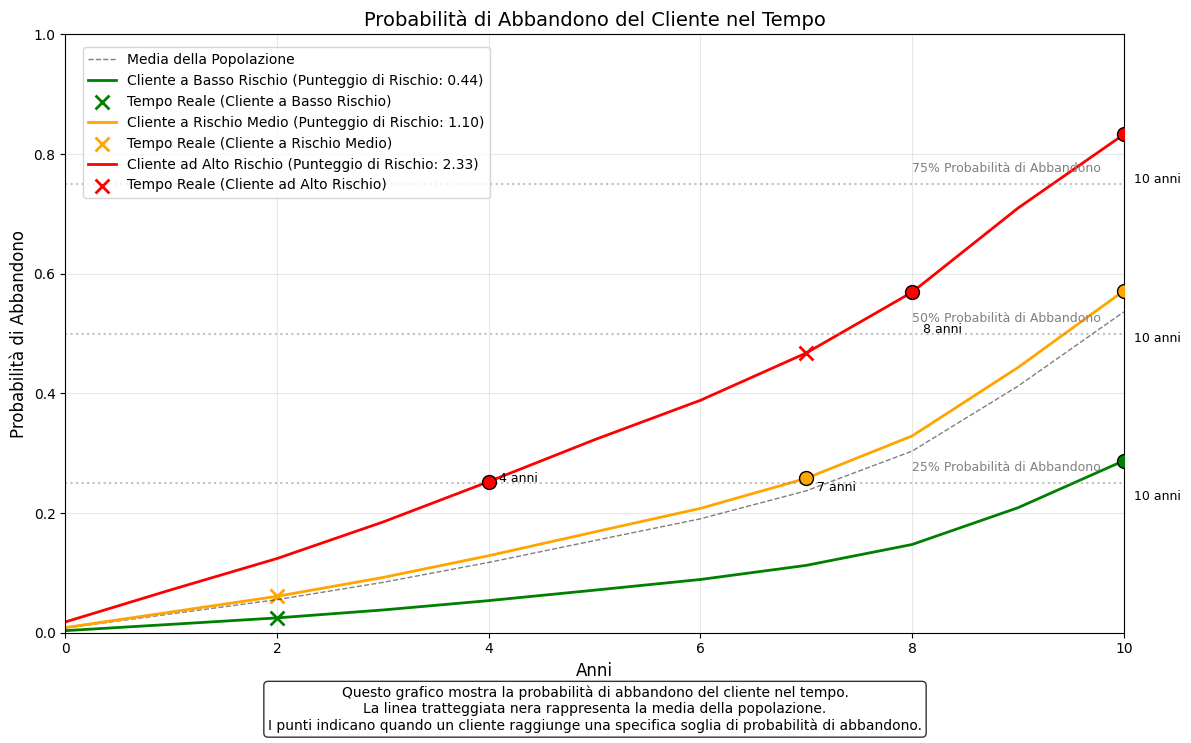

In [92]:
fig = plot_churn_probability_over_time(
    df_train=X_train_final, 
    df_test=X_test_final,
    cox_model=cph,
    test_features=pd.DataFrame(X_test_scaled, columns = X_test_df.drop(['preds', 'absolute_time_to_churn', 'Churn_Prediction'], axis = 1).columns, index = X_test_df.index),
    feature_names=X_test_df.drop(['preds', 'absolute_time_to_churn', 'Churn_Prediction'], axis = 1).columns
)

plt.show()

In [80]:
import random

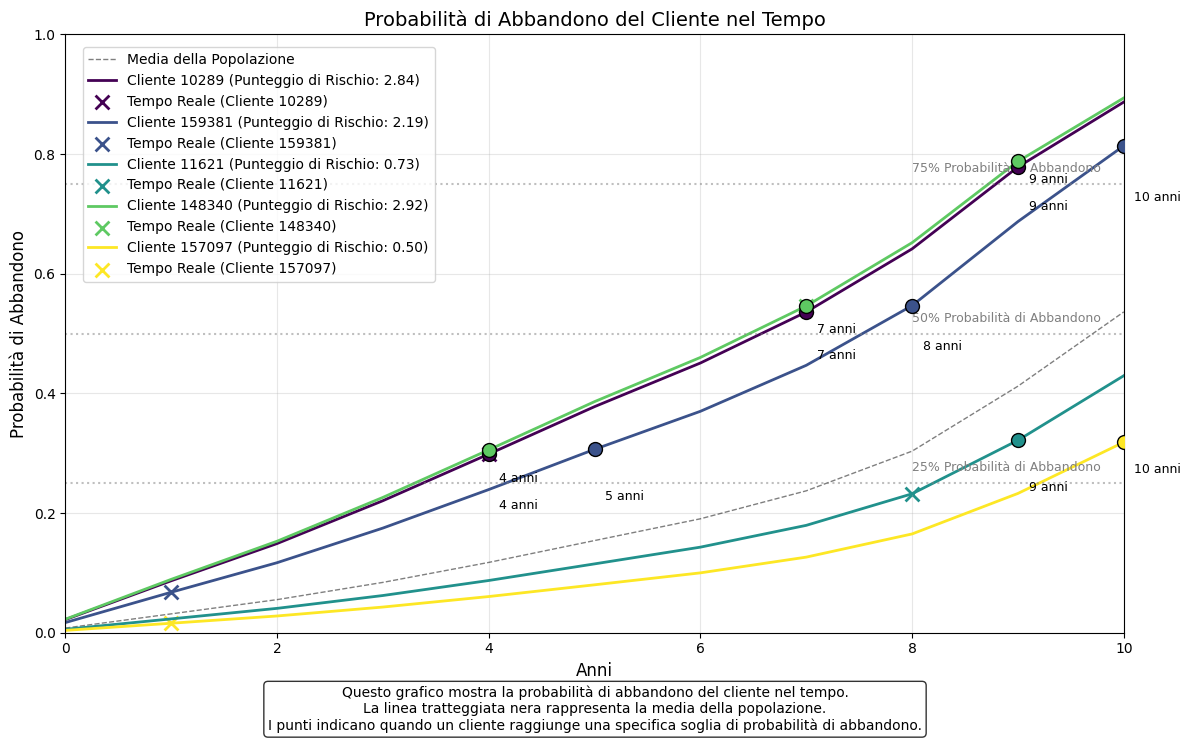

In [95]:
# Esempio di analisi su clienti specifici
random_cust = random.sample(X_test_final.index.tolist(), 5)

fig = plot_churn_probability_over_time(
    df_train=X_train_final, 
    df_test=X_test_final,
    cox_model=cph,
    test_features=pd.DataFrame(X_test_scaled, columns = X_test_df.drop(['preds', 'absolute_time_to_churn', 'Churn_Prediction'], axis = 1).columns, index = X_test_df.index),
    feature_names=X_test_df.drop(['preds', 'absolute_time_to_churn', 'Churn_Prediction'], axis = 1).columns,
    customer_indices=random_cust
)

plt.show()